In [1]:
%set_env TRANSFORMERS_CACHE=/bigstor/zsarwar/models/cache
%set_env CUDA_VISIBLE_DEVICES=3

env: TRANSFORMERS_CACHE=/bigstor/zsarwar/models/cache
env: CUDA_VISIBLE_DEVICES=3


In [2]:
import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoTokenizer, AutoModelWithLMHead, AutoModelForMaskedLM
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch.nn.functional as F
import torch
from scipy.stats import entropy
import sys


/home/zsarwar/.conda/envs/nlp2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(precision=2)
torch.set_printoptions(threshold=sys.maxsize)

In [ ]:
all_numpy_files = ["/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/bert_large_cased_2500_bert-large-cased_gpt_true_adv_token_false_remove_periods_true_add_comma_false_attempts_20.npy",
                "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/bert_large_cased_2500_bert-large-cased_gpt_true_adv_token_true_remove_periods_false_add_comma_true_attempts_20.npy"
                    
                    
]

In [ ]:
all_loaded_dicts = []
for numpy_file in all_numpy_files:
    loaded_dict = np.load(numpy_file, allow_pickle=True)
    loaded_dict = loaded_dict.item()
    all_loaded_dicts.append(loaded_dict)



In [ ]:
all_ranks_dicts = []
for l_dict in all_loaded_dicts:
    ranks = l_dict['results_adversarial']['all_first_success_ranks']
    tot_samples = len(ranks)
    cleaned_ranks = [r for r in ranks if r != -100]
    cleaned_ranks = [rank.item()+1 for rank in cleaned_ranks ]
    ranks = np.asarray(cleaned_ranks)
    min = np.min(ranks)
    max = np.max(ranks)
    
    ranks_dict = {}

    for i in range(min, max+1):
        
        curr_rank_tot = np.where(ranks == i)[0].shape[0]
        if(i != min):
            curr_rank_tot = curr_rank_tot + ranks_dict[i-1]
        ranks_dict[i] = curr_rank_tot
        #print(i, curr_rank_tot)

    for key in ranks_dict.keys():
        ranks_dict[key]/=tot_samples

    all_ranks_dicts.append(ranks_dict)

In [9]:
df = pd.DataFrame(all_ranks_dicts).T

In [10]:
df.columns = ['GPT', "GPT + Optimization"]

[Text(0.5, 0, 'Samples'), Text(0, 0.5, 'Cumulative Flip rate')]

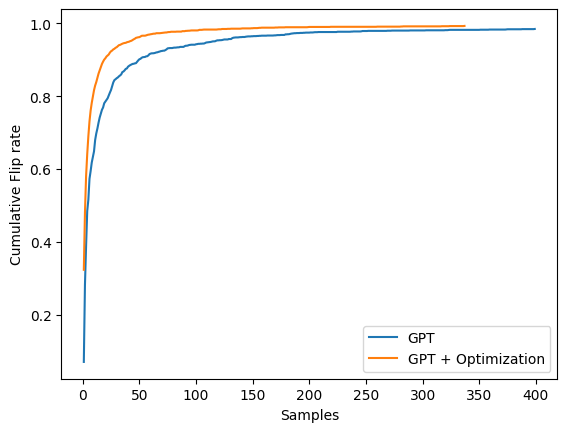

In [11]:

ax = sns.lineplot(data=df, dashes=False)
ax.set(xlabel='Samples', ylabel='Cumulative Flip rate')



In [57]:
fig = ax.get_figure()

In [58]:
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Query_Complexity.jpg", dpi=500)

# Optim Only


In [4]:
numpy_file = "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/bert_large_cased_2500_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_20_probs.npy"
loaded_dict = np.load(numpy_file, allow_pickle=True)
loaded_dict = loaded_dict.item()


In [5]:
all_first_success_probs = []
all_baseline_probs = []
all_true_labels = []
all_adv_labels = []
inc=0
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        true_label = loaded_dict['results_adversarial']['all_labels_triggers'][i][0]
        adv_label = loaded_dict['results_adversarial']['all_pred_labels_triggers'][i][first_succ_rank][0]
        adv_probs = loaded_dict['results_adversarial']['all_probs_triggers'][i][first_succ_rank.item()]
        base_probs = loaded_dict["results_baseline_real"]['all_probs_base'][i]
        all_first_success_probs.append(adv_probs)
        all_baseline_probs.append(base_probs)
        all_true_labels.append(true_label)
        all_adv_labels.append(adv_label)
    else:
        inc+=1
        

all_first_success_probs = [F.softmax(probs, dim=-1) for probs in all_first_success_probs]
all_baseline_probs = [F.softmax(probs, dim=-1) for probs in all_baseline_probs]

In [6]:
# Sorting predictions of base and adv (tokens and their predictions)
top_k = len(all_baseline_probs[0])

base_top_k = []
adv_top_k = []

probs, indices = torch.topk(all_baseline_probs[0], k=top_k, largest=True)
base_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_baseline_probs]
adv_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_first_success_probs]

In [7]:
# Track ranking of baseline top_1 before and after adversarial triggers
base_rank_prob_tracker = []
for i, label in enumerate(all_true_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    base_rank_prob_tracker.append(prob_rank_track)


In [8]:
# Track ranking of adv top_1 before and after adversarial triggers
adv_rank_prob_tracker = []
for i, label in enumerate(all_adv_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    adv_rank_prob_tracker.append(prob_rank_track)


In [9]:
# Actual analysis starts

In [10]:
  # Compute entropy of top_10 predictions

In [9]:
# Saving Top-k predictions of base and adv (tokens and their predictions)
top_10 = 10

base_top_10 = []
adv_top_10 = []

base_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_baseline_probs]
base_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in base_top_10]
base_top_10 = [probs.detach().cpu().numpy() for probs in base_top_10]
base_entropies = [entropy(b_10, base=2) for b_10 in base_top_10]
base_entropies_median = np.median(base_entropies)
base_entropies_mean = np.mean(base_entropies)
base_entropies_dev = np.std(base_entropies)


adv_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_first_success_probs]
adv_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in adv_top_10]
adv_top_10 = [probs.detach().cpu().numpy() for probs in adv_top_10]
adv_entropies = [entropy(a_10, base=2) for a_10 in adv_top_10]
adv_entropies_median = np.median(adv_entropies)
adv_entropies_mean = np.mean(adv_entropies)
adv_entropies_dev = np.std(adv_entropies)

In [12]:
df_base_entropies = pd.DataFrame(base_entropies)
#df_base_entropies.columns = ['Entropy']


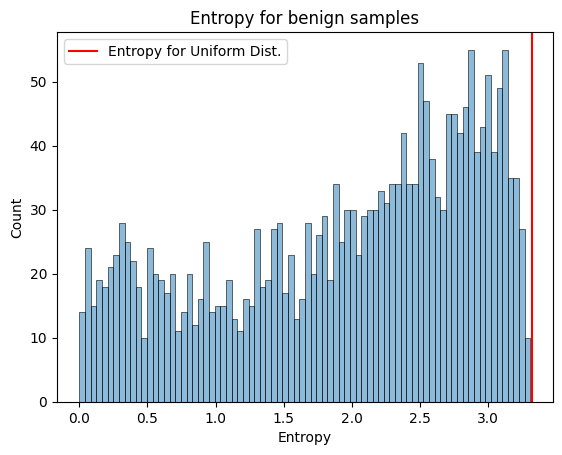

In [13]:
g = sns.histplot(data=df_base_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy for benign samples")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Baseline.jpg", dpi=500)




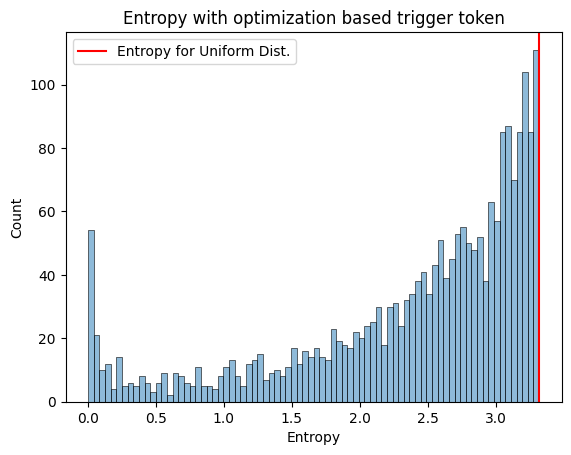

In [14]:
df_adv_entropies = pd.DataFrame(adv_entropies)
g = sns.histplot(data=df_adv_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy with optimization based trigger token")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Adv_Only_Optim.jpg", dpi=500)




In [39]:
# Plotting losses ~ CE loss tells us how confident the model was for the correct prediction 
# Can do it for True and adversarial labels in both (baseline and adversarial examples) to get an understanding of the loss surface.


In [15]:
all_first_success_losses = []
all_baseline_losses = []
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        adv_loss = loaded_dict['results_adversarial']['all_losses_triggers'][i][first_succ_rank.item()]
        # Replace "results_baseline" with "results_baseline_real" 
        base_loss = loaded_dict['results_baseline_real']['all_losses_base'][i]
        all_first_success_losses.append(adv_loss.to("cpu").item())
        all_baseline_losses.append(base_loss.to("cpu").item())
        


In [16]:
# Compute and store the loss on the adversarial tokens when they were predicted as the correct labels 
all_losses_adversarial_tokens = []
for i in range(len(all_adv_labels)):
    adv_prob = all_first_success_probs[i][all_adv_labels[i]]
    loss_on_adv = torch.log(adv_prob)
    all_losses_adversarial_tokens.append(loss_on_adv.to("cpu").item())


In [42]:
# Compute and store the delta between Top-1 and Top-2 prediction for baseline tokens
 

In [43]:
all_baseline_losses = [-loss for loss in all_baseline_losses]

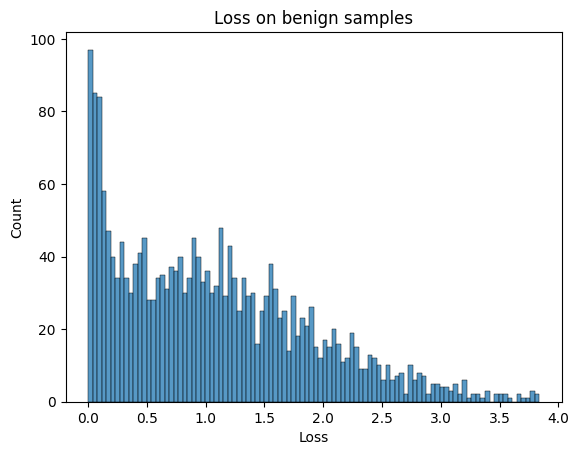

In [44]:
g = sns.histplot(data=all_baseline_losses, bins=100)
plt.xlabel("Loss")
plt.title("Loss on benign samples")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Baseline.jpg", dpi=500)



In [19]:
all_first_success_losses = [-loss for loss in all_first_success_losses]
all_losses_adversarial_tokens = [-loss for loss in all_losses_adversarial_tokens]

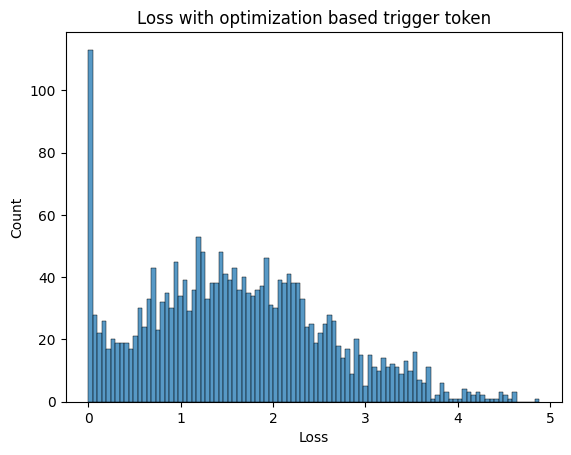

In [20]:
g = sns.histplot(data=all_losses_adversarial_tokens, bins=100)
plt.xlabel("Loss")
plt.title("Loss with optimization based trigger token")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Adversarial_Only_Optim.jpg", dpi=500)



In [47]:
# Bucket probs into Top-1, Top 2-5, 5-10, 10-Infinity

In [48]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_baseline_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_baseline_probs]
buckets_baseline = [[], [], [], []] 
for dist in all_baseline_probs_sorted_desc:
    buckets_baseline[0].append(dist[0].to("cpu").item())
    buckets_baseline[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_baseline[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_baseline[3].append(torch.sum(dist[11:]).to("cpu").item())







In [49]:
df_buckets_baseline = pd.DataFrame(buckets_baseline).T
df_buckets_baseline.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']


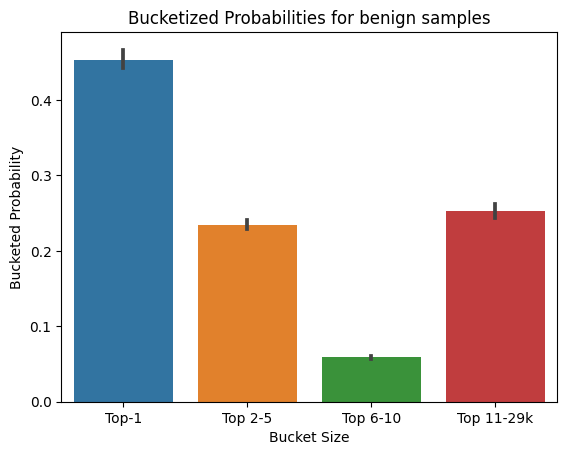

In [50]:
g = sns.barplot(data=df_buckets_baseline)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities for benign samples")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Baseline.jpg", dpi=500)


In [51]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_adv_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_first_success_probs]
buckets_adv = [[], [], [], []] 
for dist in all_adv_probs_sorted_desc:
    buckets_adv[0].append(dist[0].to("cpu").item())
    buckets_adv[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_adv[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_adv[3].append(torch.sum(dist[11:]).to("cpu").item())







In [52]:
df_buckets_adv = pd.DataFrame(buckets_adv).T
df_buckets_adv.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']


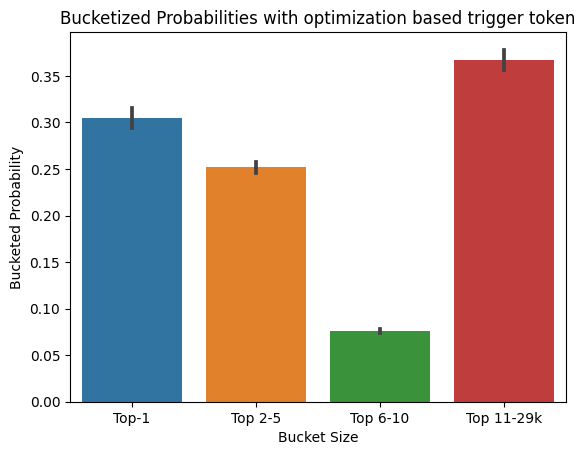

In [53]:
g = sns.barplot(data=df_buckets_adv)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities with optimization based trigger token")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Adv_Only_Optim.jpg", dpi=500)


In [10]:
base_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in base_rank_prob_tracker]
base_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in base_rank_prob_tracker]

In [11]:
df_true_labels = pd.DataFrame([base_rank_prob_tracker_og, base_rank_prob_tracker_post]).T
df_true_labels.columns = ["Benign data", "With optim. based adv token"]

In [18]:
mean_base_og = np.mean(base_rank_prob_tracker_og)
std_base_og = np.std(base_rank_prob_tracker_og)

mean_base_post = np.mean(base_rank_prob_tracker_post)
std_base_post = np.std(base_rank_prob_tracker_post)

print("Mean base OG : ", mean_base_og, "Std base OG : ", std_base_og)
print("Mean base Post : ", mean_base_post, "Std base Post : ", std_base_post)



Mean base OG :  0.45352568299177215 Std base OG :  0.29041843268282846
Mean base Post :  0.056569270624714015 Std base Post :  0.08352797014898804


0.45352568299177215

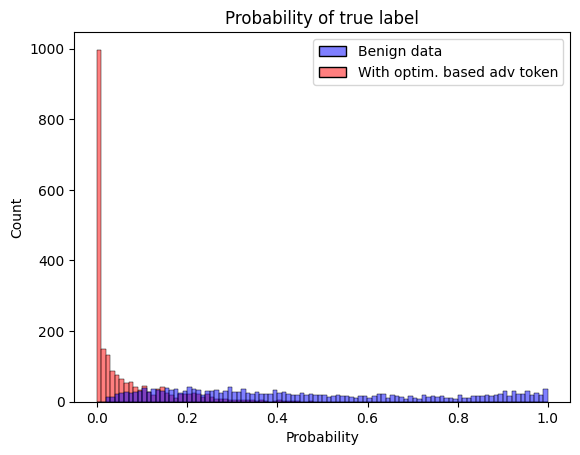

In [43]:
g = sns.histplot(data=df_true_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability of true label")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_base_optim.jpg", dpi=500)



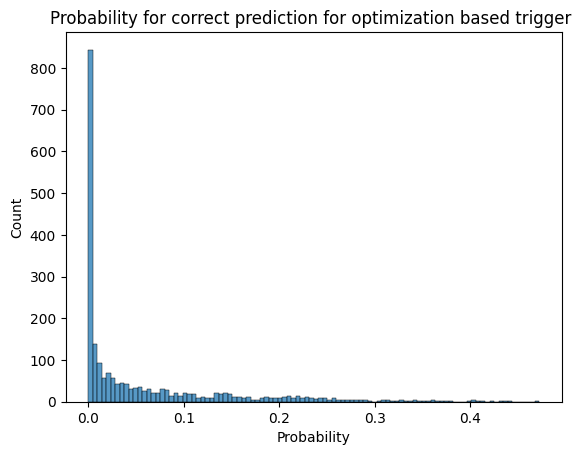

In [56]:
g = sns.histplot(data=base_rank_prob_tracker_post, bins=100)
plt.xlabel("Probability")
plt.title("Probability for correct prediction for optimization based trigger ")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_with_optim_only.jpg", dpi=500)



In [10]:
adv_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in adv_rank_prob_tracker]
adv_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in adv_rank_prob_tracker]

In [11]:
mean_adv_og = np.mean(adv_rank_prob_tracker_og)
std_adv_og = np.std(adv_rank_prob_tracker_og)

mean_adv_post = np.mean(adv_rank_prob_tracker_post)
std_adv_post = np.std(adv_rank_prob_tracker_post)

print("Mean adv OG : ", mean_adv_og, "Std adv OG : ", std_adv_og)
print("Mean adv Post : ", mean_adv_post, "Std adv Post : ", std_adv_post)

Mean adv OG :  0.03348584670431841 Std adv OG :  0.06968177210052104
Mean adv Post :  0.3050116475277276 Std adv Post :  0.26800846400639233


In [39]:
df_adv_labels = pd.DataFrame([adv_rank_prob_tracker_og, adv_rank_prob_tracker_post]).T
df_adv_labels.columns = ["Benign data", "With optim. based adv token"]

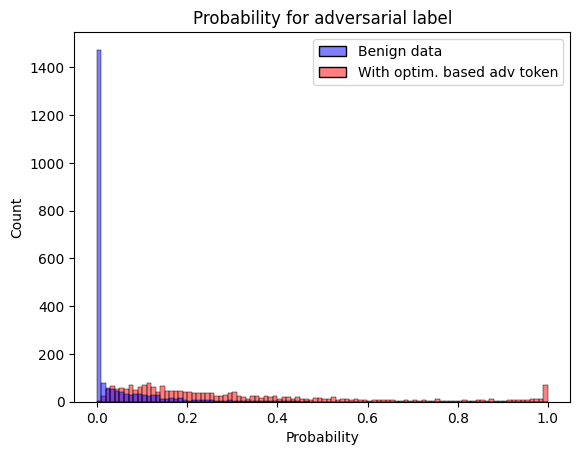

In [44]:
g = sns.histplot(data=df_adv_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability for adversarial label")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_base_optim.jpg", dpi=500)



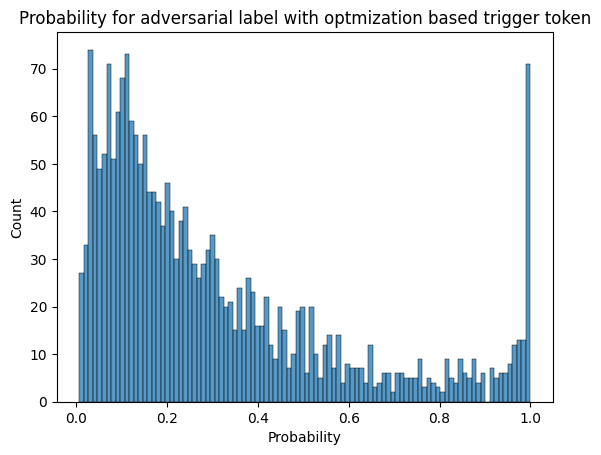

In [59]:
g = sns.histplot(data=adv_rank_prob_tracker_post, bins=100)
plt.xlabel("Probability")
plt.title("Probability for adversarial label with optmization based trigger token")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_with_optim_only.jpg", dpi=500)



# GPT + Optimization

In [4]:
numpy_file = "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/bert_large_cased_2500_bert-large-cased_gpt_true_adv_token_true_remove_periods_false_add_comma_true_attempts_20_probs.npy"
loaded_dict = np.load(numpy_file, allow_pickle=True)
loaded_dict = loaded_dict.item()


In [5]:
all_first_success_probs = []
all_baseline_probs = []
all_true_labels = []
all_adv_labels = []
inc=0
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        true_label = loaded_dict['results_adversarial']['all_labels_triggers'][i][0]
        adv_label = loaded_dict['results_adversarial']['all_pred_labels_triggers'][i][first_succ_rank][0]
        adv_probs = loaded_dict['results_adversarial']['all_probs_triggers'][i][first_succ_rank.item()]
        base_probs = loaded_dict["results_baseline_real"]['all_probs_base'][i]
        all_first_success_probs.append(adv_probs)
        all_baseline_probs.append(base_probs)
        all_true_labels.append(true_label)
        all_adv_labels.append(adv_label)
    else:
        inc+=1
        

all_first_success_probs = [F.softmax(probs, dim=-1) for probs in all_first_success_probs]
all_baseline_probs = [F.softmax(probs, dim=-1) for probs in all_baseline_probs]

In [6]:
# Sorting predictions of base and adv (tokens and their predictions)
top_k = len(all_baseline_probs[0])

base_top_k = []
adv_top_k = []

probs, indices = torch.topk(all_baseline_probs[0], k=top_k, largest=True)
base_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_baseline_probs]
adv_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_first_success_probs]

In [7]:
# Track ranking of baseline top_1 before and after adversarial triggers
base_rank_prob_tracker = []
for i, label in enumerate(all_true_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    base_rank_prob_tracker.append(prob_rank_track)


In [8]:
# Track ranking of adv top_1 before and after adversarial triggers
adv_rank_prob_tracker = []
for i, label in enumerate(all_adv_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    adv_rank_prob_tracker.append(prob_rank_track)


In [9]:
# Actual analysis starts

In [10]:
  # Compute entropy of top_10 predictions

In [11]:
# Saving Top-k predictions of base and adv (tokens and their predictions)
top_10 = 10

base_top_10 = []
adv_top_10 = []

base_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_baseline_probs]
base_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in base_top_10]
base_top_10 = [probs.detach().cpu().numpy() for probs in base_top_10]
base_entropies = [entropy(b_10, base=2) for b_10 in base_top_10]
base_entropies_median = np.median(base_entropies)
base_entropies_mean = np.mean(base_entropies)
base_entropies_dev = np.std(base_entropies)


adv_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_first_success_probs]
adv_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in adv_top_10]
adv_top_10 = [probs.detach().cpu().numpy() for probs in adv_top_10]
adv_entropies = [entropy(a_10, base=2) for a_10 in adv_top_10]
adv_entropies_median = np.median(adv_entropies)
adv_entropies_mean = np.mean(adv_entropies)
adv_entropies_dev = np.std(adv_entropies)

In [ ]:
df_base_entropies = pd.DataFrame(base_entropies)
#df_base_entropies.columns = ['Entropy']


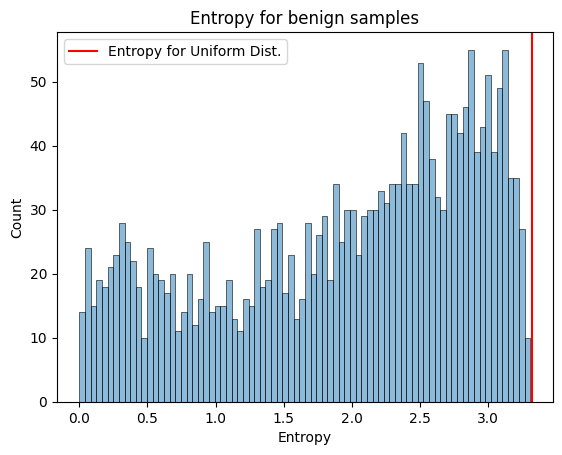

In [ ]:
g = sns.histplot(data=df_base_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy for benign samples")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Baseline.jpg", dpi=500)




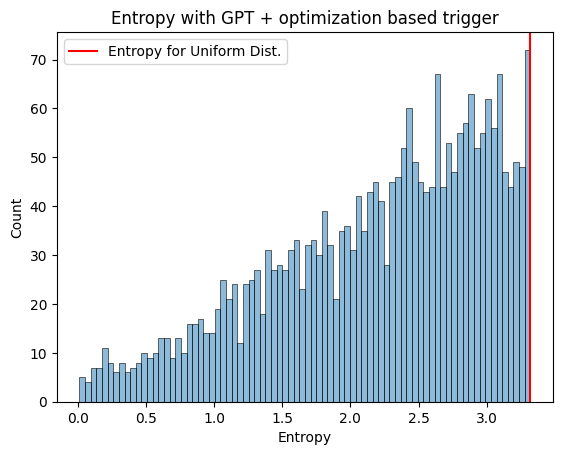

In [37]:
df_adv_entropies = pd.DataFrame(adv_entropies)
g = sns.histplot(data=df_adv_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy with GPT + optimization based trigger")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Adv_GPT_Optim.jpg", dpi=500)




In [38]:
# Plotting losses ~ CE loss tells us how confident the model was for the correct prediction 
# Can do it for True and adversarial labels in both (baseline and adversarial examples) to get an understanding of the loss surface.


In [12]:
all_first_success_losses = []
all_baseline_losses = []
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        adv_loss = loaded_dict['results_adversarial']['all_losses_triggers'][i][first_succ_rank.item()]
        # Replace "results_baseline" with "results_baseline_real" 
        base_loss = loaded_dict['results_baseline_real']['all_losses_base'][i]
        all_first_success_losses.append(adv_loss.to("cpu").item())
        all_baseline_losses.append(base_loss.to("cpu").item())
        


In [13]:
# Compute and store the loss on the adversarial tokens when they were predicted as the correct labels 
all_losses_adversarial_tokens = []
for i in range(len(all_adv_labels)):
    adv_prob = all_first_success_probs[i][all_adv_labels[i]]
    loss_on_adv = torch.log(adv_prob)
    all_losses_adversarial_tokens.append(loss_on_adv.to("cpu").item())


In [14]:
# Compute and store the delta between Top-1 and Top-2 prediction for baseline tokens
 

In [ ]:
all_baseline_losses = [-loss for loss in all_baseline_losses]

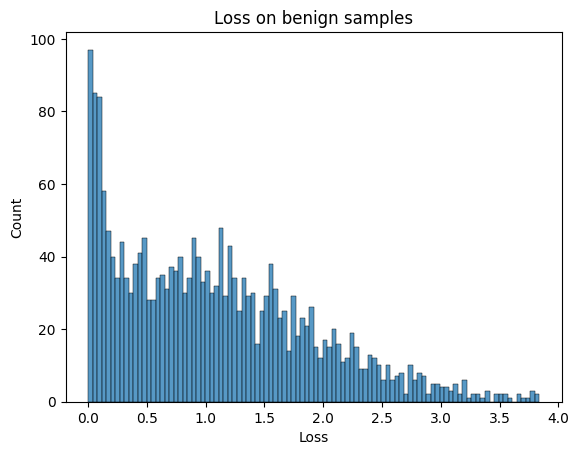

In [ ]:
g = sns.histplot(data=all_baseline_losses, bins=100)
plt.xlabel("Loss")
plt.title("Loss on benign samples")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Baseline.jpg", dpi=500)



In [15]:
all_first_success_losses = [-loss for loss in all_first_success_losses]
all_losses_adversarial_tokens = [-loss for loss in all_losses_adversarial_tokens]

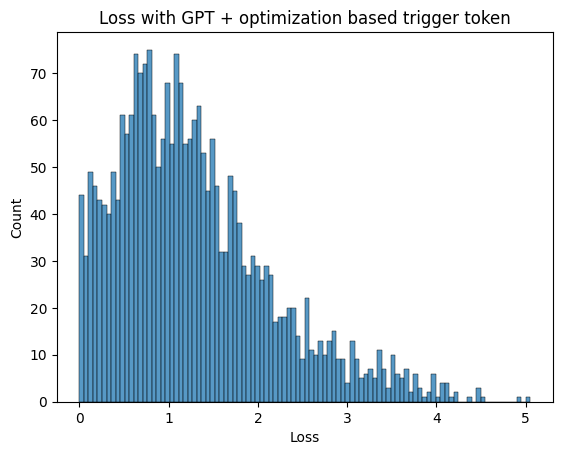

In [16]:
g = sns.histplot(data=all_losses_adversarial_tokens, bins=100)
plt.xlabel("Loss")
plt.title("Loss with GPT + optimization based trigger token")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Adversarial_GPT_Optim.jpg", dpi=500)



In [44]:
# Bucket probs into Top-1, Top 2-5, 5-10, 10-Infinity

In [22]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_baseline_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_baseline_probs]
buckets_baseline = [[], [], [], []] 
for dist in all_baseline_probs_sorted_desc:
    buckets_baseline[0].append(dist[0].to("cpu").item())
    buckets_baseline[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_baseline[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_baseline[3].append(torch.sum(dist[11:]).to("cpu").item())







In [ ]:
df_buckets_baseline = pd.DataFrame(buckets_baseline).T
df_buckets_baseline.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']


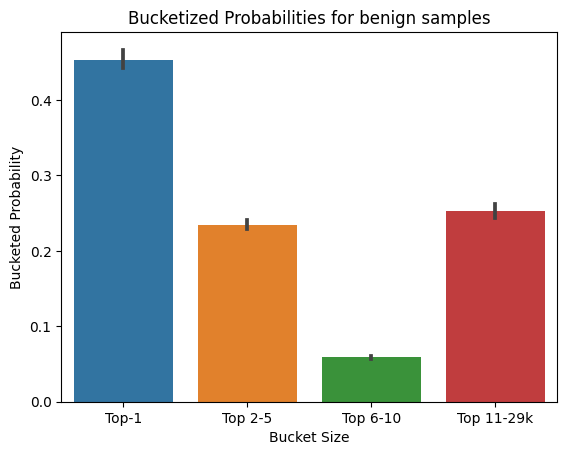

In [ ]:
g = sns.barplot(data=df_buckets_baseline)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities for benign samples")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Baseline.jpg", dpi=500)


In [45]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_adv_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_first_success_probs]
buckets_adv = [[], [], [], []] 
for dist in all_adv_probs_sorted_desc:
    buckets_adv[0].append(dist[0].to("cpu").item())
    buckets_adv[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_adv[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_adv[3].append(torch.sum(dist[11:]).to("cpu").item())







In [46]:
df_buckets_adv = pd.DataFrame(buckets_adv).T
df_buckets_adv.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']


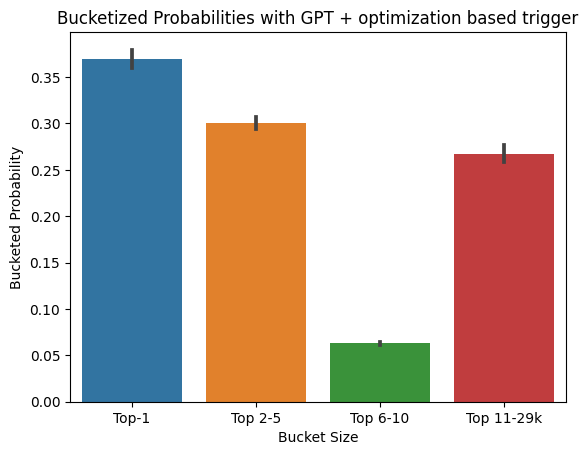

In [47]:
g = sns.barplot(data=df_buckets_adv)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities with GPT + optimization based trigger")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Adv_GPT_Optim.jpg", dpi=500)


In [9]:
base_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in base_rank_prob_tracker]
base_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in base_rank_prob_tracker]

In [10]:
mean_base_og = np.mean(base_rank_prob_tracker_og)
std_base_og = np.std(base_rank_prob_tracker_og)

mean_base_post = np.mean(base_rank_prob_tracker_post)
std_base_post = np.std(base_rank_prob_tracker_post)

print("Mean base OG : ", mean_base_og, "Std base OG : ", std_base_og)
print("Mean base Post : ", mean_base_post, "Std base Post : ", std_base_post)


Mean base OG :  0.4894681399975667 Std base OG :  0.2973696213155292
Mean base Post :  0.10638992144393715 Std base Post :  0.11037216920600812


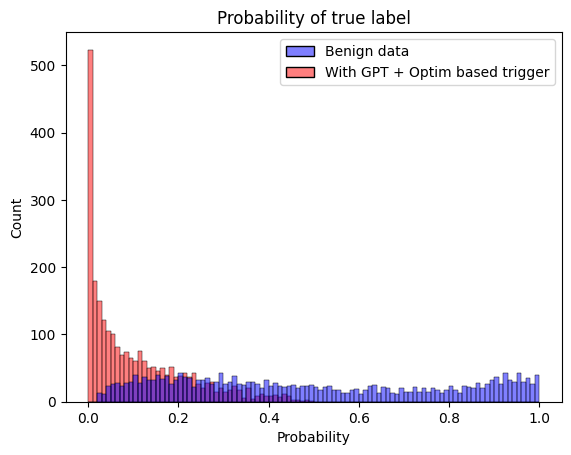

In [10]:
base_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in base_rank_prob_tracker]
base_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in base_rank_prob_tracker]

df_true_labels = pd.DataFrame([base_rank_prob_tracker_og, base_rank_prob_tracker_post]).T
df_true_labels.columns = ["Benign data", "With GPT + Optim based trigger"]


g = sns.histplot(data=df_true_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability of true label")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_base_gpt_optim.jpg", dpi=500)




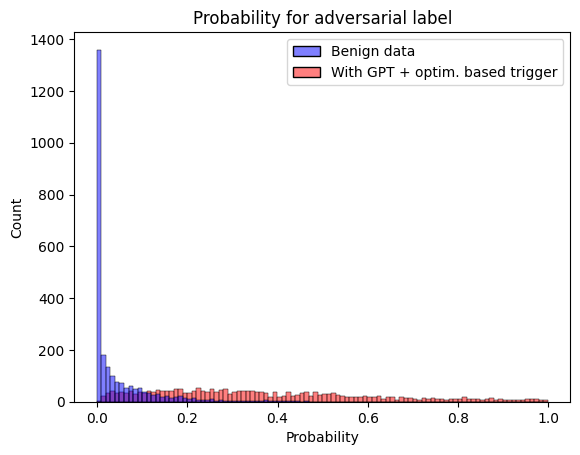

In [11]:

adv_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in adv_rank_prob_tracker]
adv_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in adv_rank_prob_tracker]

df_adv_labels = pd.DataFrame([adv_rank_prob_tracker_og, adv_rank_prob_tracker_post]).T
df_adv_labels.columns = ["Benign data", "With GPT + optim. based trigger"]

g = sns.histplot(data=df_adv_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability for adversarial label")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_base_gpt_optim.jpg", dpi=500)


In [12]:


mean_adv_og = np.mean(adv_rank_prob_tracker_og)
std_adv_og = np.std(adv_rank_prob_tracker_og)

mean_adv_post = np.mean(adv_rank_prob_tracker_post)
std_adv_post = np.std(adv_rank_prob_tracker_post)

print("Mean adv OG : ", mean_adv_og, "Std adv OG : ", std_adv_og)
print("Mean adv Post : ", mean_adv_post, "Std adv Post : ", std_adv_post)

Mean adv OG :  0.0399620629937644 Std adv OG :  0.06861026901672748
Mean adv Post :  0.369741172305654 Std adv Post :  0.2439330005469687


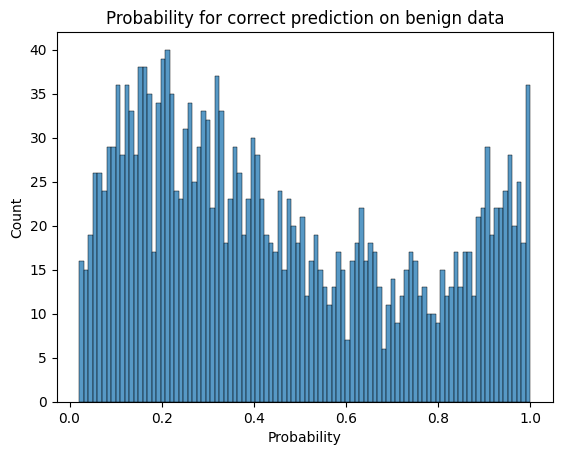

In [ ]:
g = sns.histplot(data=base_rank_prob_tracker_og, bins=100)
plt.xlabel("Probability")
plt.title("Probability for correct prediction on benign data")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_baseline.jpg", dpi=500)



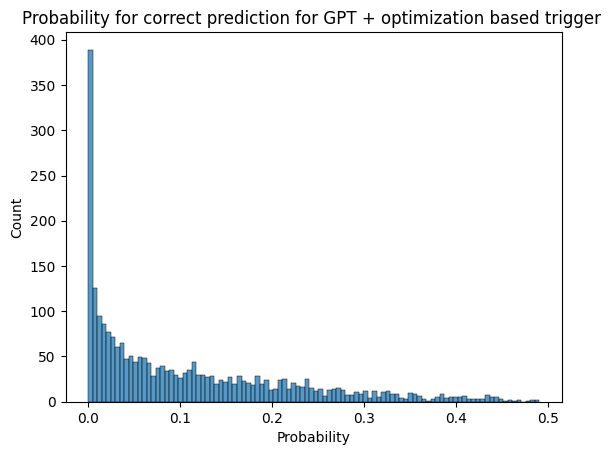

In [49]:
g = sns.histplot(data=base_rank_prob_tracker_post, bins=100)
plt.xlabel("Probability")
plt.title("Probability for correct prediction for GPT + optimization based trigger ")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_with_GPT_optim.jpg", dpi=500)



In [50]:
adv_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in adv_rank_prob_tracker]
adv_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in adv_rank_prob_tracker]

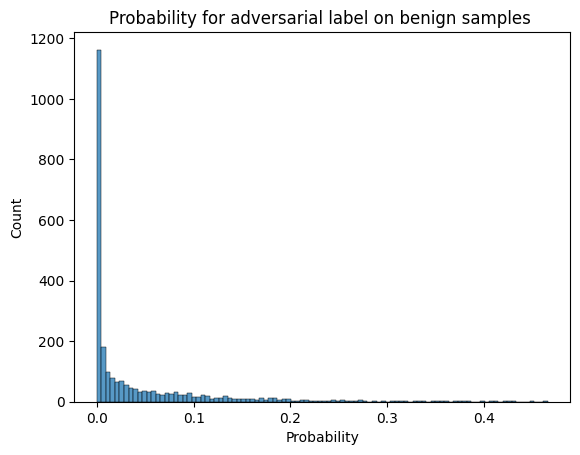

In [51]:
g = sns.histplot(data=adv_rank_prob_tracker_og, bins=100)
plt.xlabel("Probability")
plt.title("Probability for adversarial label on benign samples ")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_GPT_Optim.jpg", dpi=500)



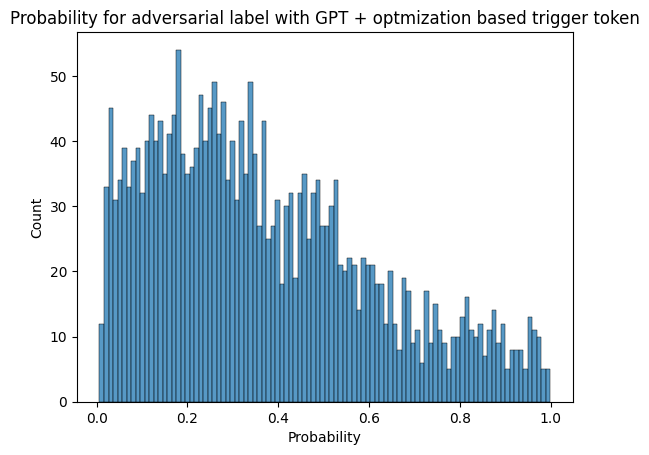

In [52]:
g = sns.histplot(data=adv_rank_prob_tracker_post, bins=100)
plt.xlabel("Probability")
plt.title("Probability for adversarial label with GPT + optmization based trigger token")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_with_gpt_optim_only.jpg", dpi=500)



# GPT Triggers only

In [4]:
numpy_file = "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/bert_large_cased_2500_bert-large-cased_gpt_true_adv_token_false_remove_periods_true_add_comma_false_attempts_20_probs.npy"
loaded_dict = np.load(numpy_file, allow_pickle=True)
loaded_dict = loaded_dict.item()


In [5]:
all_first_success_probs = []
all_baseline_probs = []
all_true_labels = []
all_adv_labels = []
inc=0
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        true_label = loaded_dict['results_adversarial']['all_labels_triggers'][i][0]
        adv_label = loaded_dict['results_adversarial']['all_pred_labels_triggers'][i][first_succ_rank][0]
        adv_probs = loaded_dict['results_adversarial']['all_probs_triggers'][i][first_succ_rank.item()]
        base_probs = loaded_dict["results_baseline_real"]['all_probs_base'][i]
        all_first_success_probs.append(adv_probs)
        all_baseline_probs.append(base_probs)
        all_true_labels.append(true_label)
        all_adv_labels.append(adv_label)
    else:
        inc+=1
        

all_first_success_probs = [F.softmax(probs, dim=-1) for probs in all_first_success_probs]
all_baseline_probs = [F.softmax(probs, dim=-1) for probs in all_baseline_probs]

In [6]:
# Sorting predictions of base and adv (tokens and their predictions)
top_k = len(all_baseline_probs[0])

base_top_k = []
adv_top_k = []

probs, indices = torch.topk(all_baseline_probs[0], k=top_k, largest=True)
base_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_baseline_probs]
adv_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_first_success_probs]

In [7]:
# Track ranking of baseline top_1 before and after adversarial triggers
base_rank_prob_tracker = []
for i, label in enumerate(all_true_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    base_rank_prob_tracker.append(prob_rank_track)


In [8]:
# Track ranking of adv top_1 before and after adversarial triggers
adv_rank_prob_tracker = []
for i, label in enumerate(all_adv_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    adv_rank_prob_tracker.append(prob_rank_track)


In [9]:
# Actual analysis starts

In [10]:
  # Compute entropy of top_10 predictions

In [11]:
# Saving Top-k predictions of base and adv (tokens and their predictions)
top_10 = 10

base_top_10 = []
adv_top_10 = []

base_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_baseline_probs]
base_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in base_top_10]
base_top_10 = [probs.detach().cpu().numpy() for probs in base_top_10]
base_entropies = [entropy(b_10, base=2) for b_10 in base_top_10]
base_entropies_median = np.median(base_entropies)
base_entropies_mean = np.mean(base_entropies)
base_entropies_dev = np.std(base_entropies)


adv_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_first_success_probs]
adv_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in adv_top_10]
adv_top_10 = [probs.detach().cpu().numpy() for probs in adv_top_10]
adv_entropies = [entropy(a_10, base=2) for a_10 in adv_top_10]
adv_entropies_median = np.median(adv_entropies)
adv_entropies_mean = np.mean(adv_entropies)
adv_entropies_dev = np.std(adv_entropies)

In [ ]:
df_base_entropies = pd.DataFrame(base_entropies)
#df_base_entropies.columns = ['Entropy']


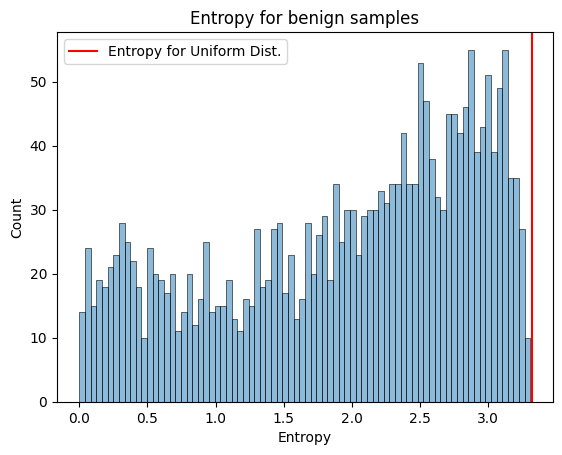

In [ ]:
g = sns.histplot(data=df_base_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy for benign samples")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Baseline.jpg", dpi=500)




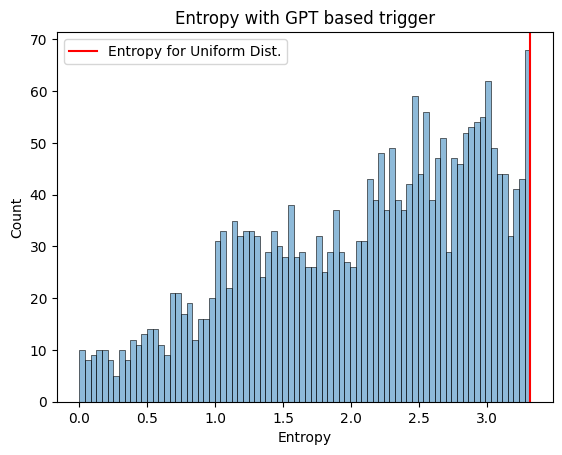

In [10]:
df_adv_entropies = pd.DataFrame(adv_entropies)
g = sns.histplot(data=df_adv_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy with GPT based trigger")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Adv_GPT.jpg", dpi=500)




In [ ]:
# Plotting losses ~ CE loss tells us how confident the model was for the correct prediction 
# Can do it for True and adversarial labels in both (baseline and adversarial examples) to get an understanding of the loss surface.


In [12]:
all_first_success_losses = []
all_baseline_losses = []
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        adv_loss = loaded_dict['results_adversarial']['all_losses_triggers'][i][first_succ_rank.item()]
        # Replace "results_baseline" with "results_baseline_real" 
        base_loss = loaded_dict['results_baseline_real']['all_losses_base'][i]
        all_first_success_losses.append(adv_loss.to("cpu").item())
        all_baseline_losses.append(base_loss.to("cpu").item())
        


In [13]:
# Compute and store the loss on the adversarial tokens when they were predicted as the correct labels 
all_losses_adversarial_tokens = []
for i in range(len(all_adv_labels)):
    adv_prob = all_first_success_probs[i][all_adv_labels[i]]
    loss_on_adv = torch.log(adv_prob)
    all_losses_adversarial_tokens.append(loss_on_adv.to("cpu").item())


In [13]:
# Compute and store the delta between Top-1 and Top-2 prediction for baseline tokens
 

In [ ]:
all_baseline_losses = [-loss for loss in all_baseline_losses]

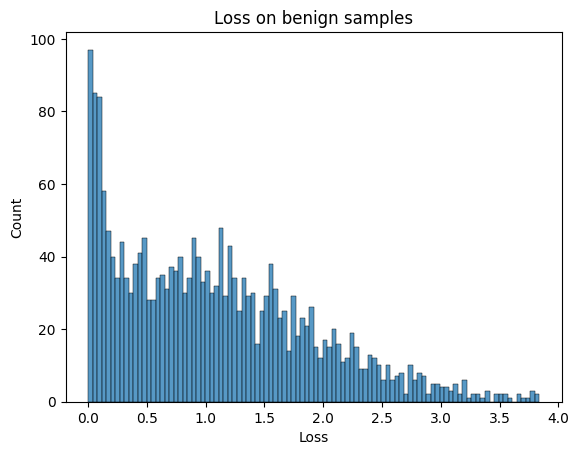

In [ ]:
g = sns.histplot(data=all_baseline_losses, bins=100)
plt.xlabel("Loss")
plt.title("Loss on benign samples")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Baseline.jpg", dpi=500)



In [14]:
all_first_success_losses = [-loss for loss in all_first_success_losses]
all_losses_adversarial_tokens = [-loss for loss in all_losses_adversarial_tokens]

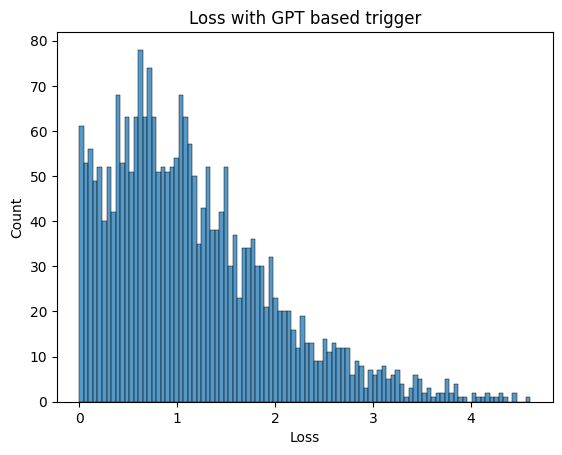

In [15]:
g = sns.histplot(data=all_losses_adversarial_tokens, bins=100)
plt.xlabel("Loss")
plt.title("Loss with GPT based trigger")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Adversarial_GPT.jpg", dpi=500)



In [ ]:
# Bucket probs into Top-1, Top 2-5, 5-10, 10-Infinity

In [16]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_baseline_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_baseline_probs]
buckets_baseline = [[], [], [], []] 
for dist in all_baseline_probs_sorted_desc:
    buckets_baseline[0].append(dist[0].to("cpu").item())
    buckets_baseline[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_baseline[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_baseline[3].append(torch.sum(dist[11:]).to("cpu").item())







In [17]:
df_buckets_baseline = pd.DataFrame(buckets_baseline).T
df_buckets_baseline.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']


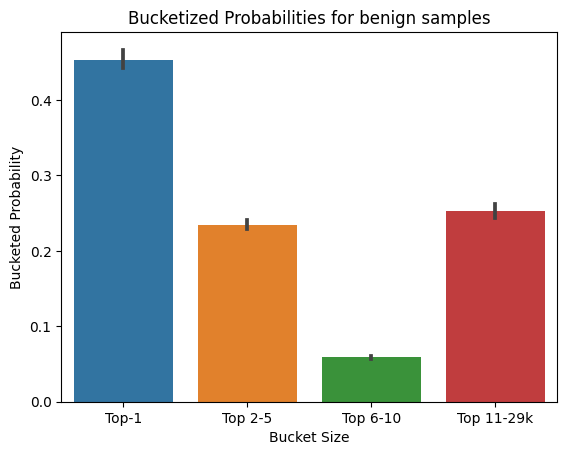

In [ ]:
g = sns.barplot(data=df_buckets_baseline)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities for benign samples")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Baseline.jpg", dpi=500)


In [18]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_adv_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_first_success_probs]
buckets_adv = [[], [], [], []] 
for dist in all_adv_probs_sorted_desc:
    buckets_adv[0].append(dist[0].to("cpu").item())
    buckets_adv[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_adv[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_adv[3].append(torch.sum(dist[11:]).to("cpu").item())







In [19]:
df_buckets_adv = pd.DataFrame(buckets_adv).T
df_buckets_adv.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']


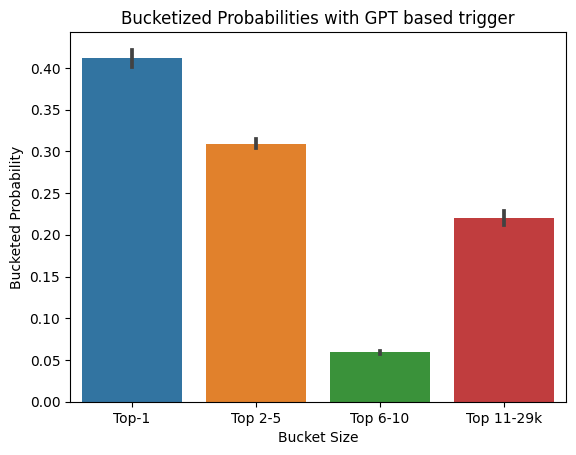

In [20]:
g = sns.barplot(data=df_buckets_adv)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities with GPT based trigger")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Adv_GPT.jpg", dpi=500)


In [10]:
base_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in base_rank_prob_tracker]
base_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in base_rank_prob_tracker]

In [11]:
mean_base_og = np.mean(base_rank_prob_tracker_og)
std_base_og = np.std(base_rank_prob_tracker_og)

mean_base_post = np.mean(base_rank_prob_tracker_post)
std_base_post = np.std(base_rank_prob_tracker_post)

print("Mean base OG : ", mean_base_og, "Std base OG : ", std_base_og)
print("Mean base Post : ", mean_base_post, "Std base Post : ", std_base_post)


Mean base OG :  0.48658103012622833 Std base OG :  0.2962100267936545
Mean base Post :  0.11997750659230517 Std base Post :  0.11415428517900421


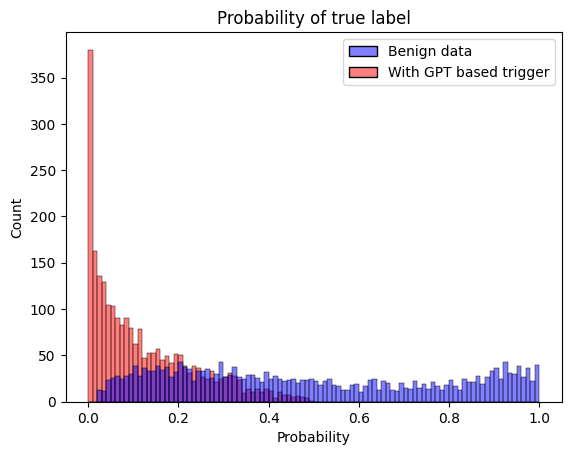

In [15]:
base_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in base_rank_prob_tracker]
base_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in base_rank_prob_tracker]

df_true_labels = pd.DataFrame([base_rank_prob_tracker_og, base_rank_prob_tracker_post]).T
df_true_labels.columns = ["Benign data", "With GPT based trigger"]


g = sns.histplot(data=df_true_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability of true label")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_base_gpt.jpg", dpi=500)




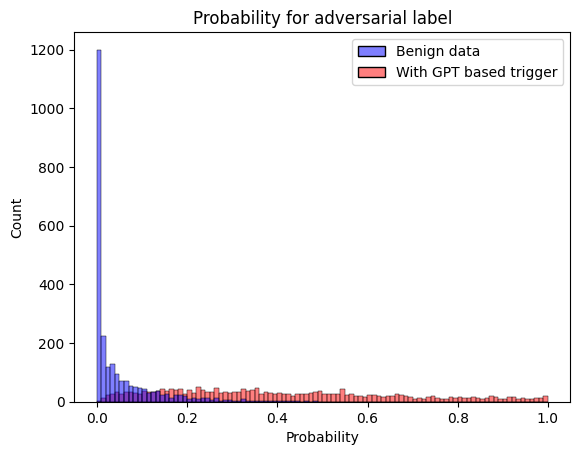

In [12]:

adv_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in adv_rank_prob_tracker]
adv_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in adv_rank_prob_tracker]

df_adv_labels = pd.DataFrame([adv_rank_prob_tracker_og, adv_rank_prob_tracker_post]).T
df_adv_labels.columns = ["Benign data", "With GPT based trigger"]

g = sns.histplot(data=df_adv_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability for adversarial label")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_base_gpt.jpg", dpi=500)


In [13]:
mean_adv_og = np.mean(adv_rank_prob_tracker_og)
std_adv_og = np.std(adv_rank_prob_tracker_og)

mean_adv_post = np.mean(adv_rank_prob_tracker_post)
std_adv_post = np.std(adv_rank_prob_tracker_post)

print("Mean adv OG : ", mean_adv_og, "Std adv OG : ", std_adv_og)
print("Mean adv Post : ", mean_adv_post, "Std adv Post : ", std_adv_post)

Mean adv OG :  0.04670238076561246 Std adv OG :  0.0747937573714592
Mean adv Post :  0.41125543062574405 Std adv Post :  0.2577022836618926


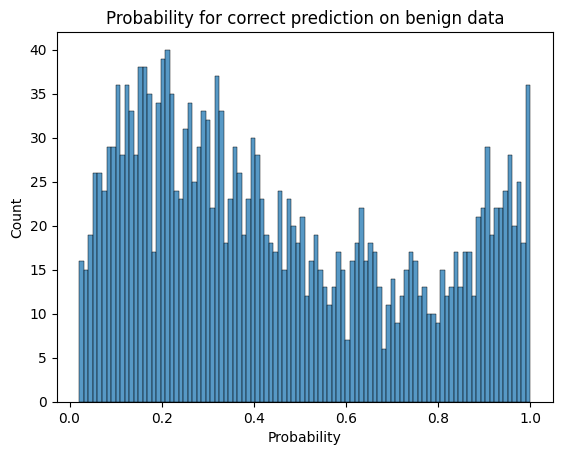

In [ ]:
g = sns.histplot(data=base_rank_prob_tracker_og, bins=100)
plt.xlabel("Probability")
plt.title("Probability for correct prediction on benign data")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_baseline.jpg", dpi=500)



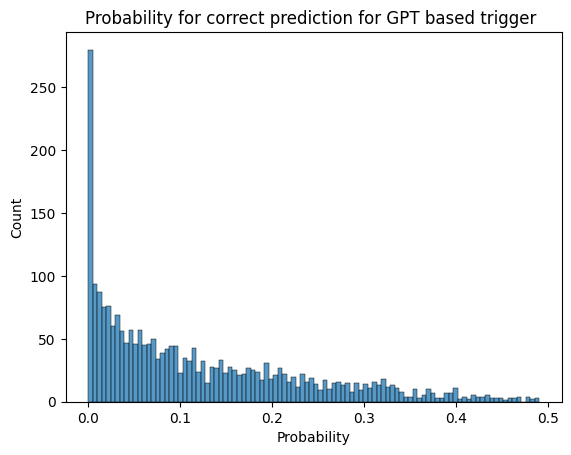

In [22]:
g = sns.histplot(data=base_rank_prob_tracker_post, bins=100)
plt.xlabel("Probability")
plt.title("Probability for correct prediction for GPT based trigger ")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_with_GPT.jpg", dpi=500)



In [23]:
adv_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in adv_rank_prob_tracker]
adv_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in adv_rank_prob_tracker]

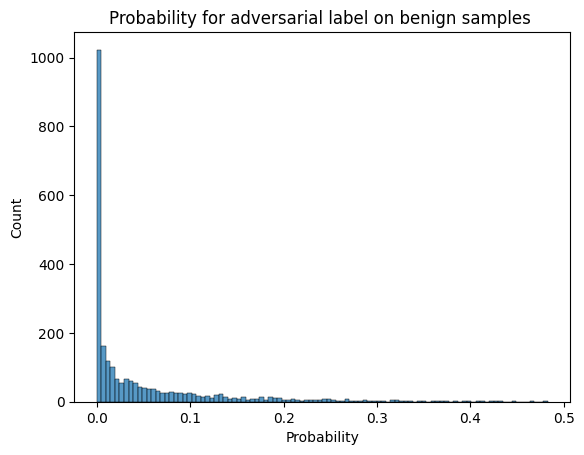

In [24]:
g = sns.histplot(data=adv_rank_prob_tracker_og, bins=100)
plt.xlabel("Probability")
plt.title("Probability for adversarial label on benign samples ")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_GPT.jpg", dpi=500)



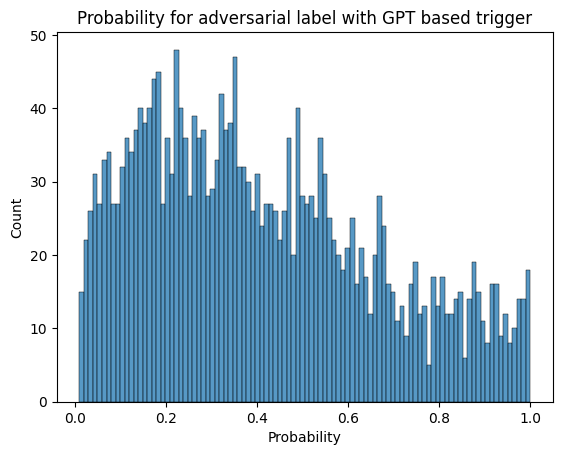

In [26]:
g = sns.histplot(data=adv_rank_prob_tracker_post, bins=100)
plt.xlabel("Probability")
plt.title("Probability for adversarial label with GPT based trigger")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_with_gpt.jpg", dpi=500)

